<a id="назад"></a> 
# Содержание
**[Постановка задачи](#постановка_задачи)**  
**[Исходные данные](#исходные)**
- [users.csv](#users.csv)
- [tariffs.csv](#tariffs.csv) 
- [calls.csv](#calls.csv)
- [messages.csv](#messages.csv)
- [internet.csv](#internet.csv)

**[Обработка](#Обработка)**  
- [Подготовка отчета](#подготовка)
- [Подсчет суммы звонков, интернет трафика и сообщений по месяцам](#сумма_по_месяцам)
- [Расчет выручки](#выручка)

**[Анализ](#Анализ)**
- [Первый взгляд](#первый_взгляд)
- [Оценка влияния "нулевых" звонков и сессий](#оценка)
- [Анализ потребления](#анализ_потребления)
- [Проверка гипотез](#гипотезы)

**[Выводы](#Выводы)**

<a id="постановка_задачи"></a> 
# Постановка задачи

Компания **«Мегалайн» — федеральный оператор сотовой связи**. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, **коммерческий департамент хочет понять, какой тариф приносит больше денег**.
Необходимо предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 3 рубля
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1 Гб интернет-трафика: 150 рублей

*Примечание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*


<a id="исходные"></a> 
# Исходные данные

In [1]:
import os
import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
calls=pd.read_csv('calls.csv')
internet=pd.read_csv('internet.csv')
messages=pd.read_csv('messages.csv')
tariffs=pd.read_csv('tariffs.csv')
users=pd.read_csv('users.csv')

### users.csv  
[в начало](#назад)

In [2]:
users
display(users.sample(5))
users.info()
print('\nКол-во дубликатов в DataFrame:', users.duplicated().sum())
print('Кол-во дубликатов в user_id:', users['user_id'].duplicated().sum())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
61,1061,41,NaN,Санкт-Петербург,Тамара,Ситникова,2018-07-15,smart
157,1157,27,NaN,Москва,Виктория,Белоусова,2018-02-23,smart
173,1173,46,NaN,Красноярск,Агафья,Григорьева,2018-06-21,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
311,1311,33,NaN,Тверь,Лолита,Крылова,2018-08-03,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Кол-во дубликатов в DataFrame: 0
Кол-во дубликатов в user_id: 0


- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

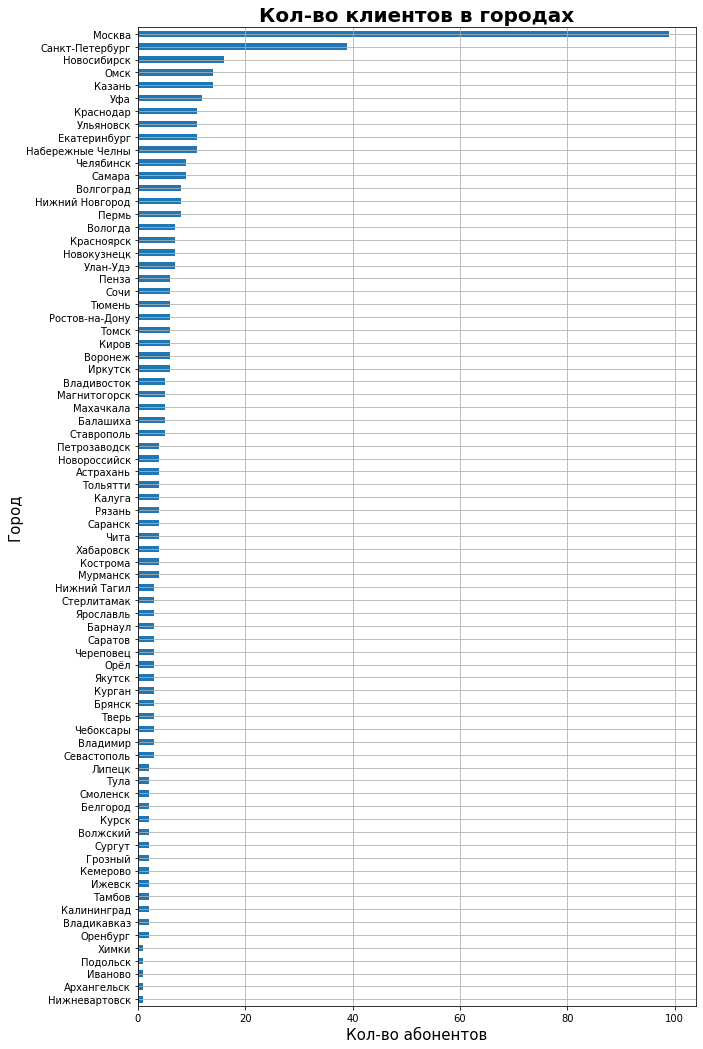

Всего городов: 76


In [3]:
# Диаграмма №1
fig=plt.figure(figsize=(10,18))
ax = fig.add_subplot(111)
# подписи
ax.set_title('Кол-во клиентов в городах',fontsize=20,fontweight='bold')
ax.set_xlabel('Кол-во абонентов',fontsize=15)
ax.set_ylabel('Город',fontsize=15)

# построение barh
users['city'].value_counts().sort_values().plot(kind='barh')

# сетка
ax.grid()

plt.show()
print('Всего городов:',len(users['city'].unique()))

<a id="соотношение"></a> 

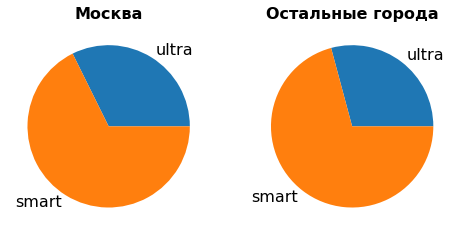

Всего
Смарт: 351
Ультра: 149


In [4]:
#Диаграмма №2
fig=plt.figure(figsize=(8,8))
#Диаграмма №2.1
ax1 = fig.add_subplot(121)
# подписи
ax1.set_title('Москва',fontsize=16,fontweight='bold')

# построение pie
users.query('city=="Москва"')['tariff'].value_counts().sort_values().plot(kind='pie',fontsize=16)
ax1.set_ylabel('')


#Диаграмма №2.2
ax2 = fig.add_subplot(122)
# подписи
ax2.set_title('Остальные города',fontsize=16,fontweight='bold')

# построение pie
users.query('city!="Москва"')['tariff'].value_counts().sort_values().plot(kind='pie',fontsize=16)
ax2.set_ylabel('')
plt.show()

# абсолютные величины
print('Всего\nСмарт:',len(users.query('tariff=="smart"')))
print('Ультра:',len(users.query('tariff=="ultra"')))


На Москву приходится ~20% выборки, при этом по соотношению тарифов Москва почти не отличается от остальных городов.  
Приведем столбцы с датой подключения и отключения тарифа к формату `datetime`. Заполним пропуски `NaN` последним днем 2018 года. Добавим столбец, содержащий время пользования тарифом. Будем хранить это значение в целых числах.

In [5]:
users['reg_date']=pd.to_datetime(users['reg_date'])
users['churn_date']=pd.to_datetime(users['churn_date'])
users['churn_date']=users['churn_date'].fillna(pd.to_datetime('2018-12-31'))

users['days_in']=(users['churn_date']-users['reg_date']).dt.days
users['days_in'].describe()

#добавим столбец с месяцем регистрации
users['reg_month']=users['reg_date'].values.astype('datetime64[M]')

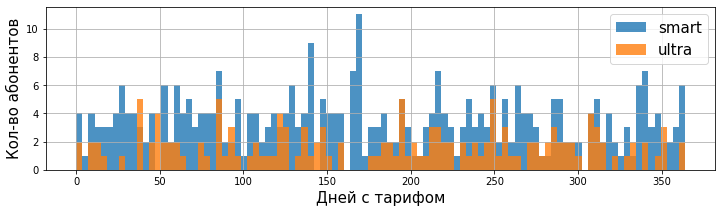

In [6]:
users.query('tariff=="smart"')['days_in'].hist(bins=100,figsize=(12,3),alpha=0.8)
users.query('tariff=="ultra"')['days_in'].hist(bins=100,figsize=(12,3),alpha=0.8)
plt.xlabel('Дней с тарифом',fontsize=15)
plt.ylabel('Кол-во абонентов',fontsize=15)
plt.legend(['smart','ultra'],fontsize=15)

Судя по гистограмме, пользователи более-менее равномерно подключали тариф в течение года (отключились только 38 из 500 клиентов).

### tariffs.csv  
[в начало](#назад)

In [7]:
display(tariffs)
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  
  
Ради удобства в будущем, переименуем столбец `tariff_name` так же, как столбец с этой информацией в таблице `users`

In [8]:
tariffs.columns=['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

### calls.csv  
[в начало](#назад1)

In [9]:
calls
display(calls.sample(5))
calls.info()
print('\nКол-во дубликатов в DataFrame:', calls.duplicated().sum())

,id,call_date,duration,user_id
180934,1453_126,2018-05-23,10.10,1453
111105,1285_33,2018-12-22,5.87,1285
3692,1009_231,2018-11-30,2.27,1009
190622,1469_241,2018-09-26,0.00,1469
30505,1077_77,2018-10-29,0.00,1077


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Кол-во дубликатов в DataFrame: 0


- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Звонков с нулевой длительностью: 39613


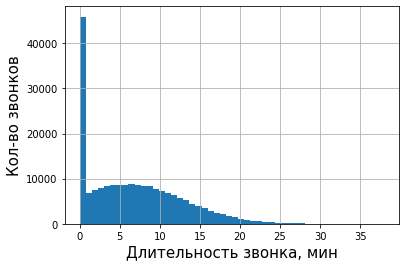

In [10]:
calls['duration'].hist(bins=50)
plt.xlabel('Длительность звонка, мин',fontsize=15)
plt.ylabel('Кол-во звонков',fontsize=15)

print('Звонков с нулевой длительностью:',len(calls.query('duration==0')))

Основных версии две:
- нулевые звонки — это пропущенные вызовы
- нулевые звонки на самом деле не нулевые, а нули в таблице образовались из-за округления  
  
Переведем дату в формат `datetime` и округлим время звонка до целого, как это принято у оператора (до целого вверх):

In [11]:
# перевод даты в формат datetime
calls['call_date']=pd.to_datetime(calls['call_date'])
calls['duration']=calls['duration'].apply(mt.ceil)

### messages.csv  
[в начало](#назад)

In [12]:
messages
display(messages.sample(5))
messages.info()
print('\nКол-во дубликатов в DataFrame:', messages.duplicated().sum())

,id,message_date,user_id
106720,1431_462,2018-08-03,1431
74396,1314_247,2018-08-31,1314
7097,1030_8,2018-07-20,1030
114522,1465_414,2018-11-19,1465
88850,1372_270,2018-05-12,1372


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Кол-во дубликатов в DataFrame: 0


- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

In [13]:
# перевод даты в формат datetime
messages['message_date']=pd.to_datetime(messages['message_date'])

### internet.csv  
[в начало](#назад)

In [14]:
internet
display(internet.sample(5))
internet.info()
print('\nКол-во дубликатов в DataFrame:', internet.duplicated().sum())

,Unnamed: 0,id,mb_used,session_date,user_id
57709,57709,1193_248,200.87,2018-09-21,1193
128636,128636,1430_58,578.85,2018-07-22,1430
50172,50172,1172_454,238.64,2018-08-26,1172
43656,43656,1150_86,66.52,2018-12-19,1150
106868,106868,1362_98,12.72,2018-08-05,1362


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

Кол-во дубликатов в DataFrame: 0


- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Кол-во сессий с нулевым трафиком: 19598


Text(0, 0.5, 'Кол-во сессий')

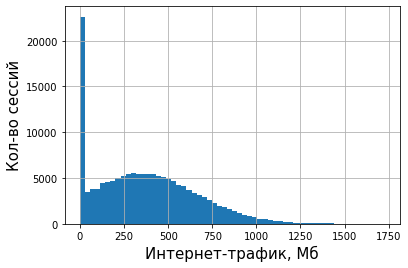

In [15]:
internet=internet[['id','mb_used','session_date','user_id']]
internet['session_date']=pd.to_datetime(internet['session_date'])
internet['mb_used']=internet['mb_used'].apply(mt.ceil)
print('Кол-во сессий с нулевым трафиком:',internet.query('mb_used==0')['mb_used'].count())
internet['mb_used'].hist(bins=60)
plt.xlabel('Интернет-трафик, Мб',fontsize=15)
plt.ylabel('Кол-во сессий',fontsize=15)

Как и в случае со звонками, в данных высокий процент сессий с нулевым трафиком. Если в случае со звонками можно было предположить, что это пропущенные вызовы, то что предположить об интернет соединении?

In [16]:
print('Кол-во уникальных пользователей с нулевым трафиком', len(internet.query('mb_used==0')['user_id'].unique()))
print('Кол-во уникальных пользователей со странными звонками', len(calls.query('duration==0')['user_id'].unique()))

Кол-во уникальных пользователей с нулевым трафиком 494
Кол-во уникальных пользователей со странными звонками 492


Похоже, явление нулевых звонков и сессий с нулевым трафиком охватывает всё множество пользователей.

In [17]:
internet.query('mb_used==0').groupby('user_id')['id'].count().describe()

count    494.000000
mean      39.672065
std       31.347392
min        1.000000
25%       13.000000
50%       31.000000
75%       62.750000
max      144.000000
Name: id, dtype: float64

Если предположить, что нули — это потери округления при выгрузке, которые оператор на самом деле приравнивает к сессиям с трафиком в 1 Мб или временем разговора в одну минуту: 

In [18]:
print('-------------------\nИнтернет\n-------------------')
display(internet.query('mb_used==0').groupby('user_id')['id'].count().describe())
print('-------------------\nЗвонки\n-------------------')
display(calls.query('duration==0').groupby('user_id')['id'].count().describe())

-------------------
Интернет
-------------------


count    494.000000
mean      39.672065
std       31.347392
min        1.000000
25%       13.000000
50%       31.000000
75%       62.750000
max      144.000000
Name: id, dtype: float64

-------------------
Звонки
-------------------


count    492.000000
mean      80.514228
std       57.484309
min        5.000000
25%       35.750000
50%       66.000000
75%      114.000000
max      336.000000
Name: id, dtype: float64

В случае с интернетом, величина при округлении не особенно впечатляет: в пределе 144 Мб, а в среднем клиент предположительно потеряет 30-40Мб на таком холостом трафике, что составляет менее процента.
В случае со звонками пользователь в среднем теряет 60-80 мин.  

# Обработка  
<a id="подготовка"></a> 
### Подготовка отчета  
[в начало](#назад)

Подготовим DataFrame `df` для сбора отчета по месяцам:

In [19]:
# генерация DataFrame столбца всех месяцев, входящих в отчетный период:
dr=pd.DataFrame(pd.date_range(pd.to_datetime('2018-01-01'),pd.to_datetime('2018-12-01'),freq='MS'))
dr.columns = ['month']

# добавление ключей для merge()
dr['key'] = 1
users['key'] = 1

# кросс джоин:
df = dr.merge(users,on='key')
df=df[['month','user_id','city','reg_month','churn_date','tariff']]

# удаление месяцев, в которых пользователь ещё/уже не зарегистрирован
df=df.query('reg_month<=month<=churn_date')

<a id="сумма_по_месяцам"></a> 
### Подсчет суммы звонков, интернет трафика и сообщений по месяцам  
[в начало](#назад)

Сгруппируем и посчитаем сумму длительности звонков за месяц:

In [20]:
# добавим столбец с месяцем звонка
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

# сгруппируем по месяцам, посчитаем суммарную длительность звонков и сохраним в DataFrame call_month
calls_month = calls.groupby(['user_id','month'])[['duration']].agg(['sum']).reset_index()

# новые названия столбцов
calls_month.columns=['user_id','month','calls_duration']

Добавим данные `calls_month` к отчетному `df`

In [21]:
df = df.merge(calls_month,how='left',on=['user_id','month'])
df.query('user_id==1000')

,month,user_id,city,reg_month,churn_date,tariff,calls_duration
406,2018-05-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,159.0
614,2018-06-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,172.0
862,2018-07-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,340.0
1154,2018-08-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,408.0
1496,2018-09-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,466.0
1871,2018-10-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,350.0
2288,2018-11-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,338.0
2738,2018-12-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,333.0


Повторим операцию для [`internet`](#internet.csv)

In [22]:
# добавим столбец с месяцем сессии
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

# сгруппируем по месяцам, посчитаем суммарный трафик и сохраним в DataFrame mb_month
mb_month = internet.groupby(['user_id','month'])[['mb_used']].agg(['sum']).reset_index()

# новые названия столбцов
mb_month.columns=['user_id','month','mb_used']

# merge() к df 
df = df.merge(mb_month,how='left',on=['user_id','month'])

...и [`messages`](#messages.csv)

In [23]:
# добавим столбец с месяцем отправленного сообщения
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

# сгруппируем по месяцам, посчитаем суммарный трафик и сохраним в DataFrame mb_month
messages_month = messages.groupby(['user_id','month'])[['id']].agg(['count']).reset_index()

# новые названия столбцов
messages_month.columns=['user_id','month','messages']

# merge() к df 
df = df.merge(messages_month,how='left',on=['user_id','month'])
df=df.fillna(0)

Посмотрим, что получилось:

In [24]:
df.query('user_id==1000')

,month,user_id,city,reg_month,churn_date,tariff,calls_duration,mb_used,messages
406,2018-05-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,159.0,2256.0,22.0
614,2018-06-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,172.0,23257.0,60.0
862,2018-07-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,340.0,14016.0,75.0
1154,2018-08-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,408.0,14070.0,81.0
1496,2018-09-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,466.0,14581.0,57.0
1871,2018-10-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,350.0,14717.0,73.0
2288,2018-11-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,338.0,14768.0,58.0
2738,2018-12-01,1000,Краснодар,2018-05-01,2018-12-31,ultra,333.0,9827.0,70.0


<a id="выручка"></a> 
### Расчет выручки  
[в начало](#назад)

Для начала добавим к `df` информацию о тарифах:

In [25]:
df = df.merge(tariffs,how='left',on=['tariff'])

Добавим функции для расчета выручки за минуты, мегабайты и сообщения сверх тарифного лимита:

In [26]:
# звонки:
def revenue_calls(row):
    delta=row['calls_duration']-row['minutes_included']
    if delta<0:
        delta=0
    row['revenue_calls']=row['rub_per_minute']*delta
    return row

# мегабайты:
def revenue_gb(row):
    delta=row['mb_used']-row['mb_per_month_included']
    if delta<0:
        delta=0
    row['revenue_gb']=row['rub_per_gb']*(delta//1024)
    return row

# сообщения:
def revenue_mess(row):
    delta=row['messages']-row['messages_included']
    if delta<0:
        delta=0
    row['revenue_messages']=row['rub_per_message']*delta
    return row

Применим функции к `df` и создадим столбец `revenue` с общей выручкой от каждого пользователя за месяц:

In [27]:
# apply():
df=df.apply(revenue_calls,axis=1)
df=df.apply(revenue_gb,axis=1)
df=df.apply(revenue_mess,axis=1)
# столбец revenue
df['revenue']=df['revenue_calls']+df['revenue_gb']+df['revenue_messages']+df['rub_monthly_fee']

# Анализ


<a id="первый_взгляд"></a> 
### Первый взгляд  
[в начало](#назад)  


Рассмотрим основные численные показатели для обоих тарифов:

Смарт:


count    2230.000000
mean     1176.995964
std       760.285788
min       550.000000
25%       550.000000
50%       917.500000
75%      1550.000000
max      6570.000000
Name: revenue, dtype: float64



Ультра


count     986.000000
mean     2050.557809
std       338.557995
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4650.000000
Name: revenue, dtype: float64

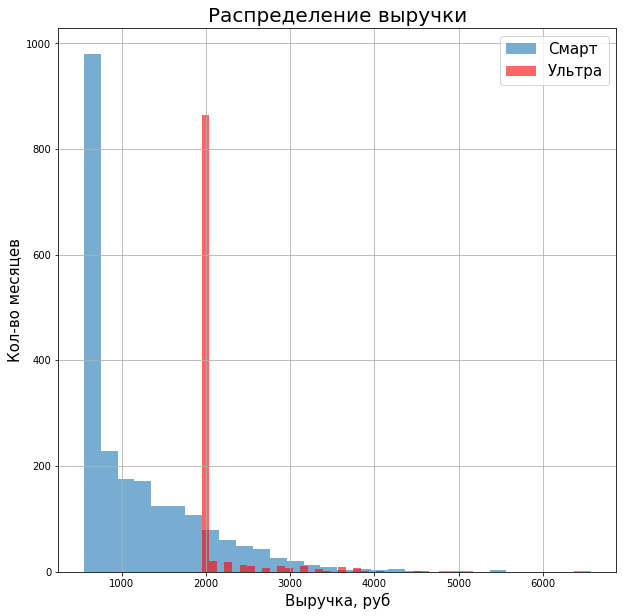

In [28]:
# функция для построения гистограмм
# dff - DataFrame
# title - заголовок
# col_name - имя колонки
# axis_name - название параметра
# bins_num - кол-во корзин (default=30)
# size - размер области построения (default=(10,10))

def hist_smart_vs_ultra(dff,title,col_name,axis_name,bins_num=30,size=(10,10)):
    plt.figure(figsize=size)
    plt.title(title,fontsize=20)
    dff.query('tariff=="smart"')[col_name].hist(bins=bins_num,alpha=0.6)
    dff.query('tariff=="ultra"')[col_name].hist(bins=bins_num, color='r',alpha=0.6,grid=True)
    plt.xlabel(axis_name,fontsize=15)
    plt.ylabel('Кол-во месяцев',fontsize=15)
    plt.legend(['Смарт','Ультра'],fontsize=15)

# Характерные значения:
print('Смарт:')
display(df.query('tariff=="smart"')['revenue'].describe())
print('\n\nУльтра')
display(df.query('tariff=="ultra"')['revenue'].describe())
# Гистограмма
hist_smart_vs_ultra(df,'Распределение выручки','revenue','Выручка, руб')

Средняя выручка тарифа `ultra` явно выше, чем у тарифа `smart`. Да и стандартное отклонение довольно невелико (338.6 против 760.3): первая квартиль, медиана и третья квартиль равны абонентской плате. А вот примерно половина абонентов с тарифом `smart` оплачивают каждый месяц чек, более чем в два раза превышающий абоненскую плату.

<a id="оценка"></a> 
### Оценка влияния "нулевых" звонков и сессий
[в начало](#назад)

Посмотрим, как изменится картина, если мы посчитаем все нулевые звонки пользователей за потери округления при выгрузке. Создадим DataFrame `df2` и заполним его скорректированными данными, используя функции из предыдущего раздела:

In [29]:
df2 = dr.merge(users,on='key')
df2=df2[['month','user_id','city','reg_month','churn_date','tariff']]
df2=df2.query('reg_month<=month<=churn_date')

# создадим копию DataFrame calls_1 и заменим в нем 0 на 1
calls_1=calls
calls_1['duration']=calls_1['duration'].replace(0,1)
# сгруппируем по месяцам, посчитаем суммарную длительность звонков и сохраним в DataFrame call_month
calls_month = calls_1.groupby(['user_id','month'])[['duration']].agg(['sum']).reset_index()
# новые названия столбцов
calls_month.columns=['user_id','month','calls_duration']


# создадим копию DataFrame calls_1 и заменим в нем 0 на 1
internet_1=internet
internet_1['mb_used']=internet_1['mb_used'].replace(0,1)
# сгруппируем по месяцам, посчитаем суммарный трафик и сохраним в DataFrame mb_month
mb_month = internet.groupby(['user_id','month'])[['mb_used']].agg(['sum']).reset_index()
# новые названия столбцов
mb_month.columns=['user_id','month','mb_used']



# сгруппируем по месяцам, посчитаем суммарный трафик и сохраним в DataFrame mb_month
messages_month = messages.groupby(['user_id','month'])[['id']].agg(['count']).reset_index()
# новые названия столбцов
messages_month.columns=['user_id','month','messages']

# merge()
df2 = df2.merge(calls_month,how='left',on=['user_id','month'])
df2 = df2.merge(mb_month,how='left',on=['user_id','month'])
df2 = df2.merge(messages_month,how='left',on=['user_id','month'])
# заполнение NaN на 0 
df2=df2.fillna(0)
df2 = df2.merge(tariffs,how='left',on=['tariff'])
# apply()
df2=df2.apply(revenue_calls,axis=1)
df2=df2.apply(revenue_gb,axis=1)
df2=df2.apply(revenue_mess,axis=1)

# revenue
df2['revenue']=df2['revenue_calls']+df2['revenue_gb']+df2['revenue_messages']+df2['rub_monthly_fee']

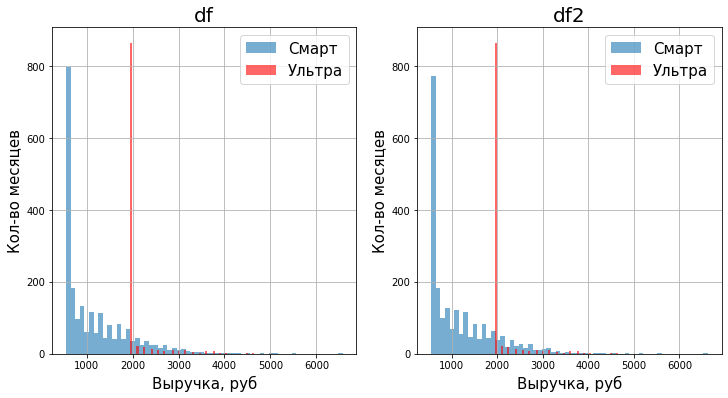

Смарт


count    2230.000000
mean     1194.771300
std       770.337037
min       550.000000
25%       550.000000
50%       950.000000
75%      1574.250000
max      6624.000000
Name: revenue, dtype: float64



Ультра:


count     986.000000
mean     2050.557809
std       338.557995
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4650.000000
Name: revenue, dtype: float64

In [30]:
# Гистограмма
# df
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('df',fontsize=20)
df.query('tariff=="smart"')['revenue'].hist(bins=60,alpha=0.6)
df.query('tariff=="ultra"')['revenue'].hist(bins=60, color='r',alpha=0.6,grid=True)
plt.xlabel('Выручка, руб',fontsize=15)
plt.ylabel('Кол-во месяцев',fontsize=15)
plt.legend(['Смарт','Ультра'],fontsize=15)

# df2
plt.subplot(1,2,2)
plt.title('df2',fontsize=20)
df2.query('tariff=="smart"')['revenue'].hist(bins=60,alpha=0.6)
df2.query('tariff=="ultra"')['revenue'].hist(bins=60, color='r',alpha=0.6,grid=True)
plt.xlabel('Выручка, руб',fontsize=15)
plt.ylabel('Кол-во месяцев',fontsize=15)
plt.legend(['Смарт','Ультра'],fontsize=15)
plt.show()
# Характерные значения
print('Смарт')
display(df2.query('tariff=="smart"')['revenue'].describe())
print('\n\nУльтра:')
display(df2.query('tariff=="ultra"')['revenue'].describe())

Как видим, оба варианта не особенно отражаются на средней выручке. Для тарифа "Смарт" она выросла на 20 руб (1-2%), а для "Ультра" вообще не изменилась.  Будемм аккуратны и оценим по нижнему краю, используя `df`

<a id="анализ_потребления"></a>
### Анализ потребления
[в начало](#назад)

Оценим, на сколько активно пользователи разных тарифов используют звонки, интернет и сообщения.

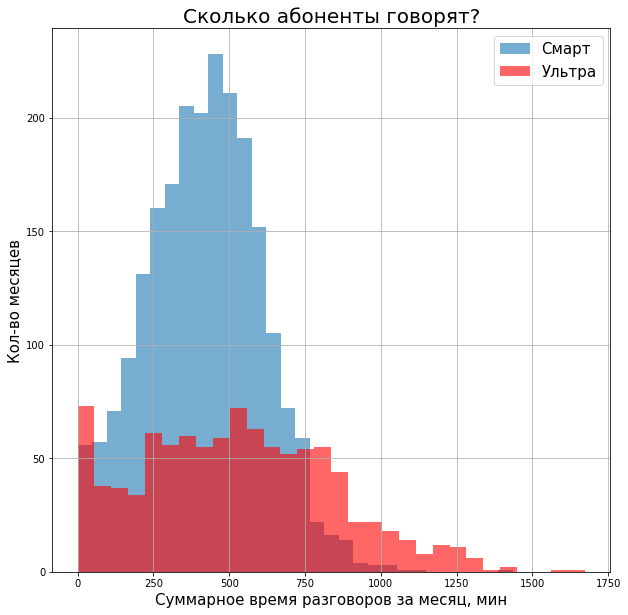

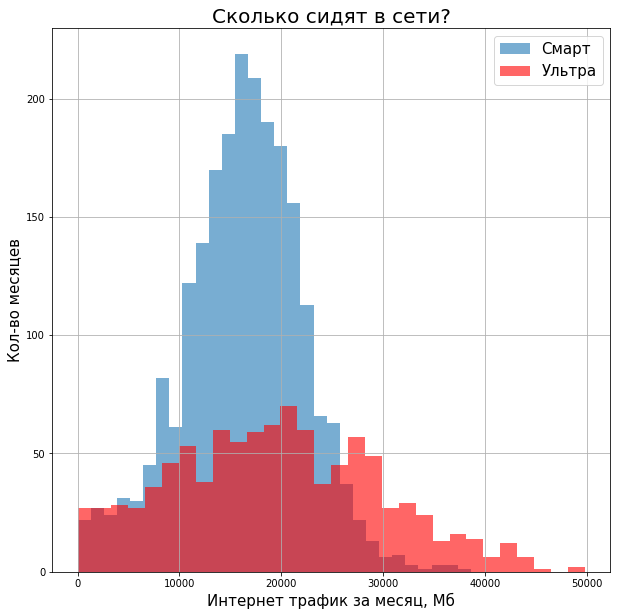

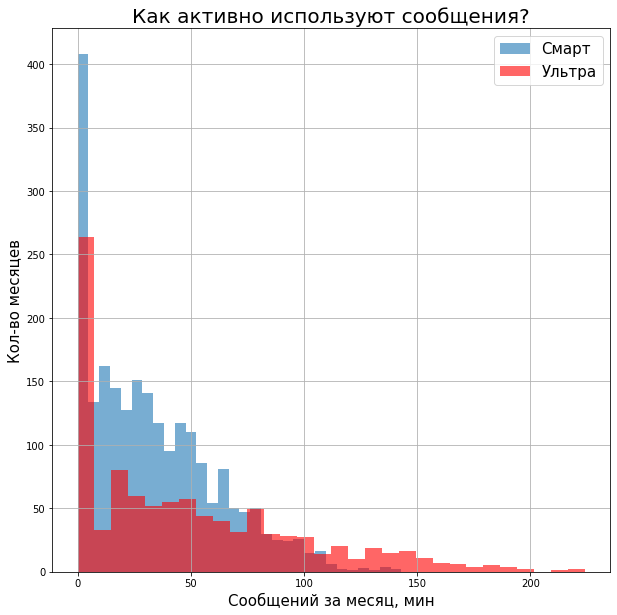

In [31]:
hist_smart_vs_ultra(df,'Сколько абоненты говорят?','calls_duration','Суммарное время разговоров за месяц, мин',30)
hist_smart_vs_ultra(df,'Сколько сидят в сети?','mb_used','Интернет трафик за месяц, Мб',30)
hist_smart_vs_ultra(df,'Как активно используют сообщения?','messages','Сообщений за месяц, мин',30)

Выведем основные показатели распределений:

In [32]:
# Функция для вывода среднего, стандартного отклонения и дисперсии по заданному параметру:
def stat_parametrs(col_name,title):
    print('-----------')
    print(title,'\n')
    print('Тариф: Смарт')
    print('Среднее: {:.3f}'.format(df2.query('tariff=="smart"')[col_name].mean()))
    print('Стд отклонение: {:.3f}'.format(df2.query('tariff=="smart"')[col_name].std()))
    print('Дисперсия {:.3f}'.format(df2.query('tariff=="smart"')[col_name].var()))
    print('\nТариф: Ультра')
    print('Среднее: {:.3f}'.format(df2.query('tariff=="ultra"')[col_name].mean()))
    print('Стд отклонение: {:.3f}'.format(df2.query('tariff=="ultra"')[col_name].std()))
    print('Дисперсия: {:.3f}'.format(df2.query('tariff=="ultra"')[col_name].var()))
    
stat_parametrs('calls_duration', 'Звонки')
stat_parametrs('mb_used', 'Интернет')
stat_parametrs('messages', 'Сообщения')

-----------
Звонки 

Тариф: Смарт
Среднее: 429.258
Стд отклонение: 195.040
Дисперсия 38040.441

Тариф: Ультра
Среднее: 540.231
Стд отклонение: 326.029
Дисперсия: 106294.600
-----------
Интернет 

Тариф: Смарт
Среднее: 16229.903
Стд отклонение: 5888.523
Дисперсия 34674707.981

Тариф: Ультра
Среднее: 19468.938
Стд отклонение: 10111.047
Дисперсия: 102233278.943
-----------
Сообщения 

Тариф: Смарт
Среднее: 33.369
Стд отклонение: 28.230
Дисперсия 796.955

Тариф: Ультра
Среднее: 49.313
Стд отклонение: 47.806
Дисперсия: 2285.417


Сравнивать эти показатели в абсолютных величинах не слишком наглядно. Поэтому посмотрим на них, нормировав по лимитам тарифов.

In [33]:
tariffs[['tariff','minutes_included','mb_per_month_included','messages_included']]

,tariff,minutes_included,mb_per_month_included,messages_included
0,smart,500,15360,50
1,ultra,3000,30720,1000


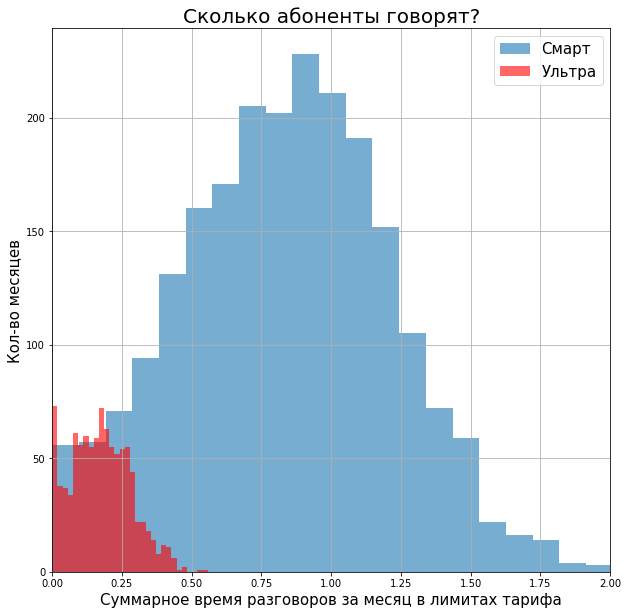

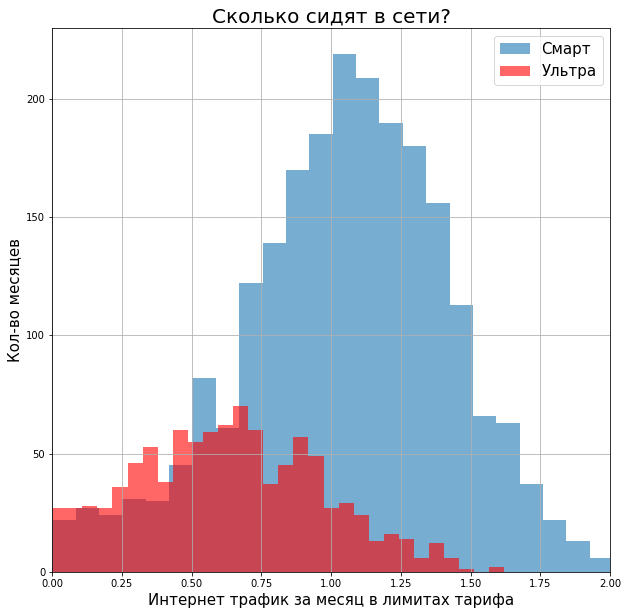

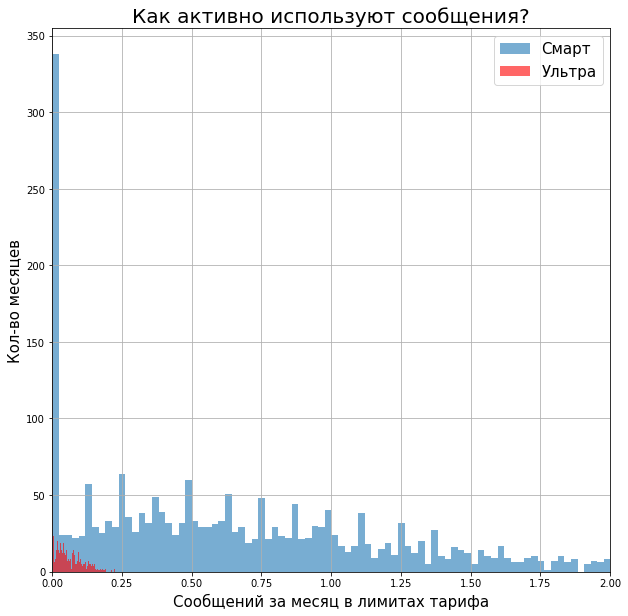

In [34]:
def hist_smart_vs_ultra_norm(dff,title,col_name,axis_name,bins_num=10, norm_s=1, norm_u=1):
    plt.figure(figsize=(10,10))
    plt.title(title,fontsize=20)
    (dff.query('tariff=="smart"')[col_name]/norm_s).hist(bins=bins_num,alpha=0.6)
    (dff.query('tariff=="ultra"')[col_name]/norm_u).hist(bins=bins_num, color='r',alpha=0.6,grid=True)
    plt.xlim(0,2)
    plt.xlabel(axis_name,fontsize=15)
    plt.ylabel('Кол-во месяцев',fontsize=15)
    plt.legend(['Смарт','Ультра'],fontsize=15)
    
hist_smart_vs_ultra_norm(df,'Сколько абоненты говорят?','calls_duration','Суммарное время разговоров за месяц в лимитах тарифа',30,500,3000)
hist_smart_vs_ultra_norm(df,'Сколько сидят в сети?','mb_used','Интернет трафик за месяц в лимитах тарифа',30,15360, 30720)
hist_smart_vs_ultra_norm(df,'Как активно используют сообщения?','messages','Сообщений за месяц в лимитах тарифа',120,50,1000)

Будем считать эффективным с точки зрения клиента использование тарифа, когда отношение расхода минут/мегабайтов/сообщений за месяц к месячному лимиту близко к 1. Из построенных гистаграмм явно видно, что:
- Распределение пользователей тарифа "Смарт" по времени звонков блико к пуассоновскому с наиболее частым значением чуть ниже установленного месячного лимита. А вот пользователи тарифа Ультра не расходуют и половины предоставленного времени.
- Распределение по интернет трафику для тарифа Смарт всё так же имеет пик около 1, а вот абоненты тарифа Ультра явно уделяют интернету больше внимания, чем звонкам. Не смотря на вдвое больший лимит, среди них тоже находится не мало пользователей выходящих за лимит трафика.
- В среднем оба тарифа отправляют примерно одинаковое (30-40) кол-во сообщений в месяц, но многие не отправляют вовсе. Тариф Ультра даже близко не приближается к своему пределу в 1000 сообщений.

Итого: пользователи тарифа Ультра говорят по телефону не многим больше, чем пользователи тарифа Смарт. А вот интернет, судя по всему, является самым востребованным ресурсом. Вероятно, именно он имел определяющее значение при выборе тарифа.

<a id="гипотезы"></a> 
### Проверка гипотез
[в начало](#назад)

**Гипотеза о среднем**
- В качестве нулевой гипотезы предположим: средняя выручка тарифов "Ультра" и "Смарт" равны.  
- В качестве альтернативной: средняя выручка тарифов "Ультра" и "Смарт" отличаются.
  
Для проверки нулевой гипотезы нам необходимо проверить утверждение о том, что средняя выручка от тарифов равна. Если точнее, то т.к. в нашей выборке средние для этих тарифов очевидно различны, нам необходимо оценить вероятность, с которой подобное различие могло получиться случайно. 
У нас две независимые выборки. Воспользуемся t-тестом Стьюдента:

In [35]:
# критический уровень статистической значимости
alpha = 0.01
# проверка гипотезы о равенстве средних
results = st.ttest_ind(df.query('tariff=="smart"')['revenue'],df.query('tariff=="ultra"')['revenue'])
print('p-value:',results.pvalue) #p-value

p-value: 3.496214201498474e-223


Как и предполагалось, средняя выручка с пользователя за месяц для тарифов отличается. Для случайного совпадения было бы необходимо огромное число пользователей с тарифом "Смарт", которые в месяц умудрялись бы наговорить много больше чем на 4 абонентских платы. Даже если такие люди существуют, большинство из них скорее всего давно задумалось бы о смене тарифа на более подходящий - поэтому вероятность исчезающе мала.
  
Тариф "Ультра" приносит больше и сильно более предсказуем - его стандартное отклонение ниже, а среднее почти вдвое выше. Три четверти пользователей не выбиваются за лимиты, установленные тарифом. Суммарная прогнозируемая выручка для этого тарифа будет близка к произведению кол-ва абонентов на абонентскую плату.

**Гипотеза о Москве и регионах**  
- В качестве нулевой гипотезы предположим: средняя выручка для Москвы и регионов одинакова.  
- В качестве альтернативной: средняя выручка для Москвы и регионов отличается.

Перед нами задача похожая на предыдущую и для оценки вероятности логично использовать тот же критерий.

In [36]:
print('Средняя выручка по Москве: {:.2f} руб'.format(df.query('city=="Москва"')['revenue'].mean()))
print('Средняя выручка в регионах: {:.2f} руб'.format(df.query('city!="Москва"')['revenue'].mean()))

# проверка гипотезы о равенстве средних
results = st.ttest_ind(df.query('city=="Москва"')['revenue'],df.query('city!="Москва"')['revenue'])
# p-значение:
print('p-value:',results.pvalue) # p-value

Средняя выручка по Москве: 1470.04 руб
Средняя выручка в регионах: 1438.91 руб
p-value: 0.3706849604906597


Опровергнуть нулевую гипотезу не удалось. Как видим, среднее значение для обеих выборок отличаются всего на пару процентов, так что нет ничего удивительного в том, что случайное различие между ними можно получить примерно в 37% случаев. Это значит, что с большой долей вероятности средняя выручка за месяц от пользователя в Москве не будет значительно отличаться от выручки с пользователя в регионах.

# Выводы

[в начало](#назад)

В результате исследования выборки из 500 пользователей удалось установить: 
- Больше в среднем за месяц приносят пользователи тарифа "Ультра". При этом пользователи данного тарифа достаточно редко превышают установленные лимиты (расходуют не весь оплаченный ими трафик). **Можно рекомендовать коммерческому департаменту "Мегалайна" активнее продвигать тариф "Ультра"**  
- Гипотеза о том, что средняя выручка за месяц от пользователя в Москве выше выручки пользователя из регионов, оказалась не верна.
- В маркетинговой компании скорее всего следуют уделить **максимальное внимание предоставляемому интернет-трафику**